# Introduction

Text is one of the most widespread forms of sequence data. It can be understood as either a sequence of charactors or a sequence of words, but it's most common to work at level of words. Text-sequence processing includes following applications:

**Applications of deep learning for text data:**
1. Document classification
2. Articles lebelling
3. Sentiment analysis
4. Author identification
5. Question-answering
6. Language detection
7. Translation Tasks

- In true sense `deep learning models map the statistical structure of written language,` which is sufficient to solve many simple textual tasks and problems.
- Deep learning for natural-language processing is `pattern recognition applied to words, sequence, and paragraphs,` in much similar way that computer vision is pattern recognition applied to pixels.
- Deep-learning models don't take input as text like other models they only work with numeric tensors

**Three techniques to vectorize the text data:**
1. Segment text into words, and convert word into a vector
2. Segment text into charactors, and transform each chractors into a vector.
3. Extract n-grams of words, and transform each n-grams into a vector.

- There are many ways one can convert text to vector and it depends on what models one is using along with time or resources utilization.

**Typical workflow to prepare text data for machine learning models:**
1. Tokenization
2. One-Hot encoding or word indexing
3. Pad sequencing 
4. Embedding layer (Word2Vec)
5. Corresponding word vector

- In this notebook, we are going to explore and solve news classification problem to classify 41 types of news headlines and news descriptions.

**Use-case:** Such text classification models are used in `News Apps` or by reporter to classify news topics for better reach to right audience.

**Problem-statement:** Build `news classification model` using deep learning teechniques and deploy model for reporters to classify and label news articles.

*Reference: Deep learning with python by Francois Chollet*

# Table of contents:

0. [Importing libraries](#lib)
1. [Data exploration and pre-processing](#eda)

  - [Profiling report of dataset](#pp)
  - [Text data visualization](#td)
  - [Text data pre-processing](#tdp)
  
  
2. [Tokenization and vectorization](#tv)
3. [What are the word embeddings?](#we)
4. [Model training using EmbeddingLayer,RNNs and LSTMs](#rnn) 

  - [Baseline model 1](#base)
  - [What are the RNNs?](#rnets)
  - [Model training using LSTM](#model2)
  - [Loss and accuracy curve](#loss)
  
  
5. [Conclusion](#conclude)

# 0. Importing libraries

<a id="lib"></a>


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import ydata_profiling as pp
from markupsafe import escape
# from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
# plt.style.use("ggplot")
# plt.rc("figure", autolayout=True)
# plt.rc(
#     "axes",
#     labelweight="bold",
#     labelsize="large",
#     titleweight="bold",
#     titlesize=14,
#     titlepad=10,
# )

# import warnings 
# warnings.filterwarnings('ignore')
# nltk.download('omw-1.4')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# # Generate data profiling report
# profile = pp.ProfileReport(df)
# profile.to_file("output.html")

# 1. Data exploration and pre-processing

<a id="eda"></a>


In [3]:
df = pd.read_json('../dataset/raw/News_Category_Dataset.json', lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [4]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(209527, 6)
Unique categories: 42
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [5]:
# general descrption of dataset
df.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

,date
count,209527
mean,2015-04-30 00:44:14.344308736
min,2012-01-28 00:00:00
25%,2013-08-10 00:00:00
50%,2015-03-16 00:00:00
75%,2016-11-01 00:00:00
max,2022-09-23 00:00:00


## 1.1 Profiling report of dataset

<a id="pp"></a>


In [6]:
from ydata_profiling import ProfileReport

# Generate Pandas Profiling report
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)


**Key findings:**

1. Dataset has total **41** distinct categories of news articles
2. **'Politics'** is the most common category of news in our dataset.
3. We have total of **27993** unique authors who have written various news articles
4. Maximum length of headline is **320** while median length is around **59.**
5. Maximum length of description is **1472** while median length is around **120.**

## 1.2 Text data visualization

<a id="td"></a>


In [7]:
# drop columns like authors, links and date as they are irrelevent to our problem.
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


### 1.2.1 TOP 10 Categories of News Articles

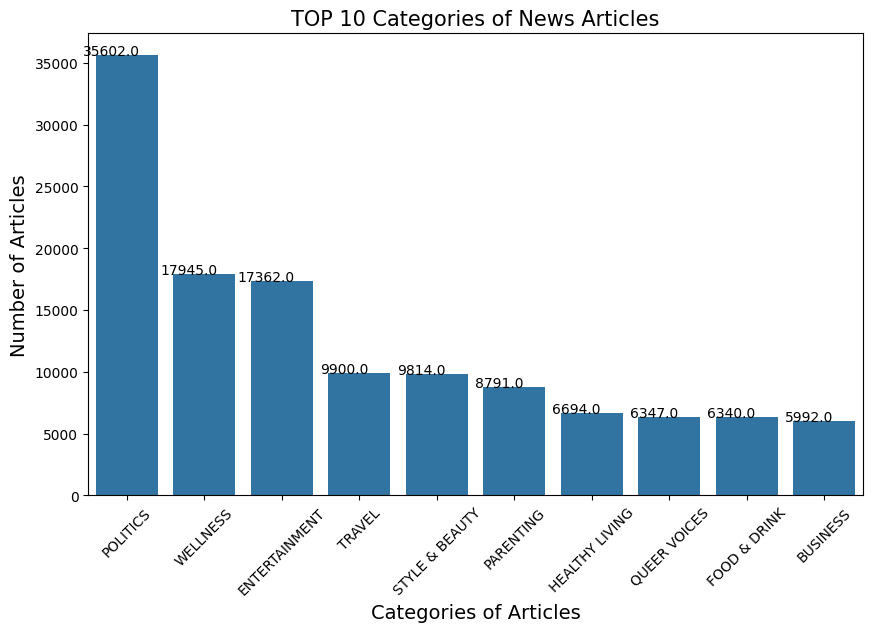

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Top categories by and number of articles per categories
cat_df = new_df['category'].value_counts().reset_index()
cat_df.columns = ['news_classes', 'numcat']

# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='news_classes', y='numcat', data=cat_df[:10])  # Specify x, y, and data
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.2, p.get_height() + 0.5), ha='center')
plt.title("TOP 10 Categories of News Articles", size=15)
plt.xlabel("Categories of Articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of Articles", size=14)
plt.show()


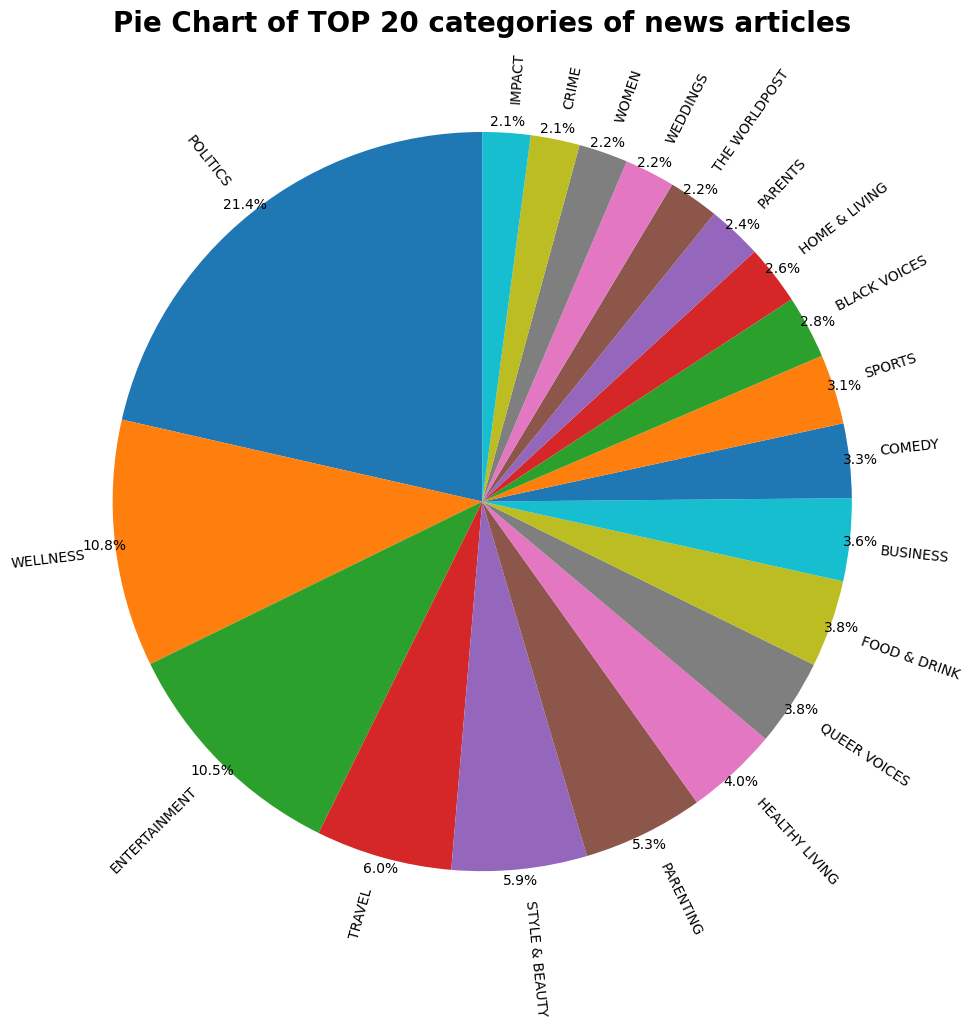

In [9]:
# plot the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:20],
            labels=cat_df['news_classes'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 20 categories of news articles", size=20, weight='bold')
plt.show()

### 1.2.2 Lengths of 'headline' and 'short_description' of each category

In [10]:
# create final dataframe of combined headline and short_description
final_df = new_df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

,category,length_of_news,len_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,230
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",248
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,133
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,215
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,233


In [11]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

,category,len_news
24,POLITICS,1486
41,WORLDPOST,1424
4,COLLEGE,1225
16,HEALTHY LIVING,1073
38,WELLNESS,1036


In [12]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

,category,len_news
35,U.S. NEWS,73
8,DIVORCE,66
33,THE WORLDPOST,56
36,WEDDINGS,54
21,MONEY,51


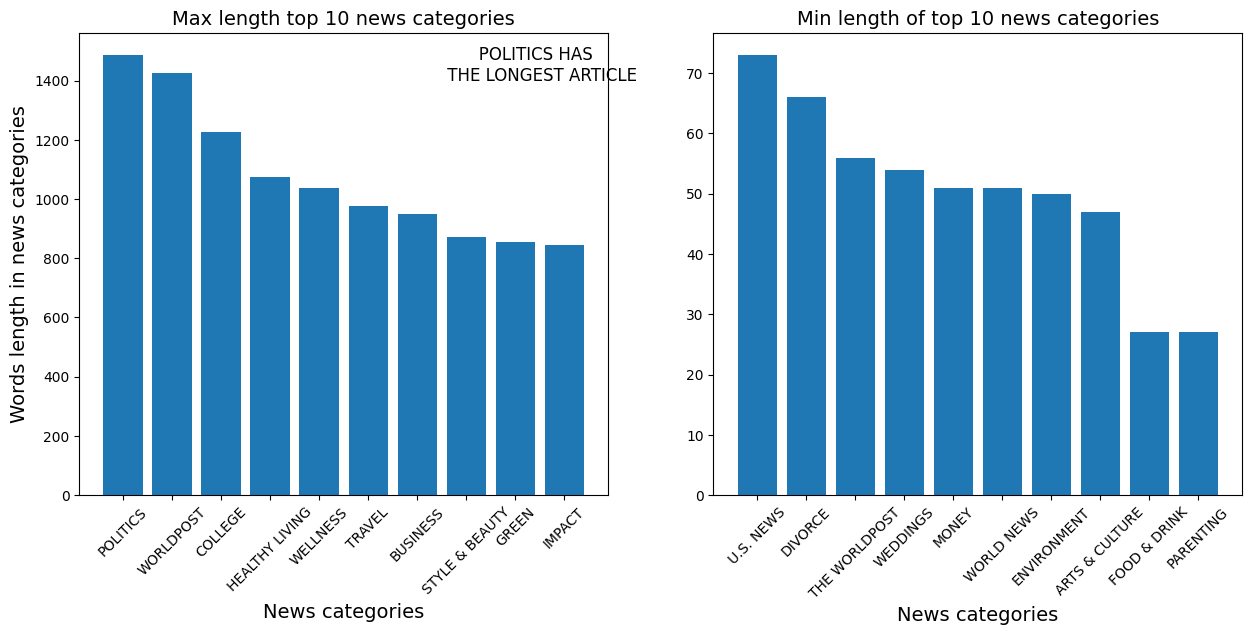

In [13]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:10],lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS 
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['category'][:10], lenmin_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

**Key findings:**

1. From all the categories of news **POLITICS** has the **most number of articles** as well as **length of characters** in the article (headlines and short-description)
2. After 'POLITICS' category, 'WORLDPOST', 'COLLEGE', 'HEALTHY LIVING','WELLNESS' categories are in top 5 most length of articles
3. 'POLITICS', 'WELLNESS' and 'ENTERTAINTMENT' are top 3 categories having most number of articles in out dataset.

### 1.2.3 Wordclouds of categories and news articles

- Wordcloud of categories in out dataframe
- Wordcloud of new articles in each of the categories

In [14]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(final_df.category))

plt.title("41 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

NameError: name 'WordCloud' is not defined

<Figure size 1200x1200 with 0 Axes>

In [15]:
# create new dataframe of category and length of each news articles in that categories
ndf = final_df.copy()
ndf.drop('len_news', inplace=True, axis=1)

# list of top 10  categories in out dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)
    
# create a wordcloud instance
wc1 = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

NameError: name 'WordCloud' is not defined

## 1.3 Text-data Preprocessing 

<a id="tdp"></a>


In [16]:
# start with removing some data from politics dataframe ndf
politics_list = list(ndf[ndf['category'] == 'POLITICS'].index) 
list_16 = politics_list[:16000] # list of 16000 row labels of POLITICS category

# drop these 16000 labels from the dataset
ndf2 = ndf.copy()
ndf2.drop(list_16, axis=0, inplace=True)
ndf2

,category,length_of_news
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,PARENTING,The Funniest Tweets From Parents This Week (Se...
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...
...,...,...
209522,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...
209523,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...
209524,SPORTS,"Giants Over Patriots, Jets Over Colts Among M..."
209525,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...


In [17]:
# Cek jumlah data duplikat sebelum penghapusan
initial_duplicates = ndf2.duplicated().sum()
print(f'Jumlah data duplikat sebelum penghapusan: {initial_duplicates}')

# Menghapus data duplikat
new_df = ndf2.drop_duplicates()

# Cek jumlah data duplikat setelah penghapusan
final_duplicates = new_df.duplicated().sum()
print(f'Jumlah data duplikat setelah penghapusan: {final_duplicates}')

Jumlah data duplikat sebelum penghapusan: 465
Jumlah data duplikat setelah penghapusan: 0


In [18]:
# Menampilkan kategori unik setelah filter
unique_categories = ndf2['category'].unique()
print("Unique categories:", unique_categories)


Unique categories: ['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'WEIRD NEWS' 'ENVIRONMENT' 'EDUCATION' 'CRIME'
 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY' 'FOOD & DRINK' 'MEDIA'
 'QUEER VOICES' 'HOME & LIVING' 'WOMEN' 'BLACK VOICES' 'TRAVEL' 'MONEY'
 'RELIGION' 'LATINO VOICES' 'IMPACT' 'WEDDINGS' 'COLLEGE' 'PARENTS'
 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE' 'HEALTHY LIVING' 'THE WORLDPOST'
 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS' 'POLITICS' 'DIVORCE']


In [19]:
# Definisikan mapping kategori lama ke kategori baru
category_mapping = {
    'U.S. NEWS': 'News', 'WORLD NEWS': 'News', 'POLITICS': 'News',
    'CRIME': 'News', 'GOOD NEWS': 'News', 'WORLDPOST': 'News', 'THE WORLDPOST': 'News',
    'ENTERTAINMENT': 'Entertainment', 'COMEDY': 'Entertainment', 'ARTS': 'Entertainment',
    'CULTURE & ARTS': 'Entertainment', 'STYLE': 'Entertainment', 'STYLE & BEAUTY': 'Entertainment',
    'WOMEN': 'Entertainment', 'FIFTY': 'Entertainment', 'DIVORCE': 'Entertainment', 'WEDDINGS': 'Entertainment',
    'SPORTS': 'Sports', 'TECH': 'Technology', 'SCIENCE': 'Science',
    'WELLNESS': 'Health', 'HEALTHY LIVING': 'Health', 'ENVIRONMENT': 'Environment',
    'GREEN': 'Environment', 'HOME & LIVING': 'Lifestyle', 'TRAVEL': 'Lifestyle',
    'FOOD & DRINK': 'Lifestyle', 'TASTE': 'Lifestyle', 'PARENTS': 'Lifestyle',
    'PARENTING': 'Lifestyle', 'BUSINESS': 'Business & Money', 'MONEY': 'Business & Money',
    'QUEER VOICES': 'Social Issues', 'BLACK VOICES': 'Social Issues', 'LATINO VOICES': 'Social Issues',
    'IMPACT': 'Social Issues', 'RELIGION': 'Social Issues', 'MEDIA': 'Social Issues',
    'EDUCATION': 'Social Issues', 'COLLEGE': 'Social Issues'
}

# Terapkan pengelompokan ke kolom 'category'
ndf2['category_general'] = ndf2['category'].map(category_mapping)

# Tampilkan kategori umum yang terbentuk
print("Kategori umum setelah pengelompokan:", ndf2['category_general'].unique())

# Periksa jumlah kategori di setiap kategori baru
print(ndf2['category_general'].value_counts())


Kategori umum setelah pengelompokan: ['News' 'Entertainment' 'Lifestyle' 'Technology' 'Sports' nan
 'Environment' 'Social Issues' 'Science' 'Health' 'Business & Money']
category_general
Entertainment       49465
News                35481
Lifestyle           35402
Health              24639
Social Issues       23223
Business & Money     7748
Sports               5077
Environment          4066
Science              2206
Technology           2104
Name: count, dtype: int64


In [22]:
ndf2

,category,length_of_news,category_general
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,News
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",News
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,Entertainment
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,Lifestyle
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,News
...,...,...,...
209522,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Technology
209523,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,Sports
209524,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",Sports
209525,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,Sports


In [23]:
# Hapus kolom 'category' dari ndf2
ndf2 = ndf2.drop(columns=['category'])

# Periksa DataFrame untuk memastikan kolom dihapus
ndf2


,length_of_news,category_general
0,Over 4 Million Americans Roll Up Sleeves For O...,News
1,"American Airlines Flyer Charged, Banned For Li...",News
2,23 Of The Funniest Tweets About Cats And Dogs ...,Entertainment
3,The Funniest Tweets From Parents This Week (Se...,Lifestyle
4,Woman Who Called Cops On Black Bird-Watcher Lo...,News
...,...,...
209522,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Technology
209523,Maria Sharapova Stunned By Victoria Azarenka I...,Sports
209524,"Giants Over Patriots, Jets Over Colts Among M...",Sports
209525,Aldon Smith Arrested: 49ers Linebacker Busted ...,Sports


In [24]:
# Menghapus baris yang berisi null value
total_empty_rows = ndf2.isnull().any(axis=1).sum()
print(f"Total baris dengan nilai kosong: {total_empty_rows}")

# Menghapus baris yang memiliki nilai kosong (NaN) di salah satu kolom
ndf2 = ndf2.dropna()

# Menampilkan jumlah nilai kosong (NaN) setelah penghapusan
empty_rows_after = ndf2.isnull().sum()
print("Jumlah nilai kosong per kolom setelah penghapusan:")
print(empty_rows_after)


Total baris dengan nilai kosong: 0
Jumlah nilai kosong per kolom setelah penghapusan:
length_of_news      0
category_general    0
dtype: int64


In [30]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Pastikan stopwords dan lemmatizer tersedia
nltk.download('stopwords')
nltk.download('wordnet')

STOPWORDS = set(stopwords.words('english'))  # Menggunakan stopwords dari nltk

def datacleaning(text):
    # Regex patterns
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    
    # Substitusi dengan regex
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub(r"\d+", "", text)  # Raw string untuk \d+
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    # Removing stop-words
    text = [word for word in text.split() if word not in STOPWORDS]
    
    # Word lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word, 'v') for word in text]
    
    return ' '.join(text)


[nltk_data] Downloading package stopwords to C:\Users\Annisa
[nltk_data]     Fadila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Annisa
[nltk_data]     Fadila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
# Pastikan kolom 'length_of_news' memiliki teks
ndf2.reset_index(drop=True, inplace=True)

# Contoh pre-processing
print("Text sentence before pre-processing:\n", ndf2['length_of_news'][0])
print("---" * 35)
print("Text sentence after pre-processing:\n", datacleaning(ndf2['length_of_news'][0]))


Text sentence before pre-processing:
 Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID BoostersHealth experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 million americans roll sleeves omicrontargeted covid boostershealth experts say early predict whether demand would match million dose new boosters us order fall


In [32]:
print(ndf2.index)  # Melihat indeks DataFrame

RangeIndex(start=0, stop=189411, step=1)


In [33]:
# apply datacleaning function to column 'length_of_news'
ndf2['length_of_news'] = ndf2['length_of_news'].apply(datacleaning)

In [34]:
# length of total characters before and after cleaning text data
old_length = ndf['length_of_news'].apply(len).sum()
new_length = ndf2['length_of_news'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 36169394
New chracters length of text data: 22838146


In [35]:
# length of total words before and after cleaning text data
old_text = ndf['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = ndf2['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 5942993
New word length of text data: 3260836


# 2. Tokenization and vectorization

<a id="tv"></a>


### Some of the most common NLP terminologies

**1. Document**
- Each and every training example used in text dataset known as a Document.

**2. Corpus**
- Collections of documents called as a corpus of text data

**3. Vocabulary(BoW)**
- Vocabulary or Bag-of-words is nothing but number of unique words are present in text corpus.

**4. Stop words**
- Stop words are those used most commonly in any language, e.g. 'the', 'a', etc. they do not form any meaning to the context of the text

**5. N-grams**
- N-grams is text representation in form of N words sequences to extract meaning and context out of each sentences or paragraphs.

**6. Tokenization**
- It's an early step in NLP process to split text sentences into smaller words or tokens.

**7. Vectorization**
- Machine do not understand text or words, so text data or tokens must be converted to corrospinding word index or word vectors in order process text and build models. process of converting tokenized words into numerical vectors called as a vectorization.

### One-hot encoding and word-indexing example on chunk of data

In [36]:
# tokenization and vectorization workflow
# word level one-hot encoding for sample data

samples = list(ndf2['length_of_news'][:5].values)  # samples of first 5 documents of out dataset

token_index = {}  # builds an index of tokens in the data
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # assigning unique index to each unique words
            
max_length = 15

results = np.zeros(shape=(len(samples),   # results will be stored in this array
                          max_length,
                          max(token_index.values()) +1)) 

print("Shape of stored results array:", results.shape)
print("Token index of unique words: \n", token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape of stored results array: (5, 15, 94)
Token index of unique words: 
 {'million': 1, 'americans': 2, 'roll': 3, 'sleeves': 4, 'omicrontargeted': 5, 'covid': 6, 'boostershealth': 7, 'experts': 8, 'say': 9, 'early': 10, 'predict': 11, 'whether': 12, 'demand': 13, 'would': 14, 'match': 15, 'dose': 16, 'new': 17, 'boosters': 18, 'us': 19, 'order': 20, 'fall': 21, 'american': 22, 'airlines': 23, 'flyer': 24, 'charge': 25, 'ban': 26, 'life': 27, 'punch': 28, 'flight': 29, 'attendant': 30, 'videohe': 31, 'subdue': 32, 'passengers': 33, 'crew': 34, 'flee': 35, 'back': 36, 'aircraft': 37, 'confrontation': 38, 'accord': 39, 'attorneys': 40, 'office': 41, 'los': 42, 'angeles': 43, 'funniest': 44, 'tweet': 45, 'cat': 46, 'dog': 47, 'week': 48, 'sept': 49, 'dont': 50, 'understand': 51, 'could': 52, 'eat': 53, 'parent': 54, 'accidentally': 55, 'put': 56, 'grownup': 57, 'toothpaste': 58, 'toddlers': 59, 'toothbrush': 60, 'scream': 61, 'like': 62, 'clean': 63, 'teeth': 64, 'carolina': 65, 'reaper'

### One-hot encoding and indexing of train and test data

In [72]:
ndf2

,length_of_news,category_general
0,million americans roll sleeves omicrontargeted...,News
1,american airlines flyer charge ban life punch ...,News
2,funniest tweet cat dog week sept dog dont unde...,Entertainment
3,funniest tweet parent week sept accidentally p...,Lifestyle
4,woman call cop black birdwatcher lose lawsuit ...,News
...,...,...
189406,rim ceo thorsten heins significant plan blackb...,Technology
189407,maria sharapova stun victoria azarenka austral...,Sports
189408,giants patriots jet colts among improbable sup...,Sports
189409,aldon smith arrest ers linebacker bust duicorr...,Sports


In [73]:
# one hot encoding using keras tokenizer and pad sequencing
X = ndf2['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(ndf2['category_general'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 130 # max length of sequence 
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print("Length of word index:", total_words)

shape of input data:  (189411,)
shape of target variable:  (189411,)
Length of word index: 178004


# 3. What are the Wordembeddings?

<a id="we"></a>


> A word embedding is a learned representation for text where words that have the same meaning and save similar representation

Reference:- [Machinelearningmastery](https://machinelearningmastery.com/what-are-word-embeddings/)

- This approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on chllengin NLP problems
- Word embeddings are alternative to one-hot encoding along with dimensionality reduction

> One-hot word vectors - Sparse, High-dimensional and Hard-coded 

> Word embeddings - Dense, Lower-Dimensional and Learned from the data

- Keras library has embeddings layer which does word representation of given text corpus 

**tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs
)**

**Key Arguments:**

1) input_dim - Size of vocabulary - length of word index

2) output_dim - Output dimention of word representation

3) input-length - max input sequence length of document

**Visual depiction of word embeddings:-**

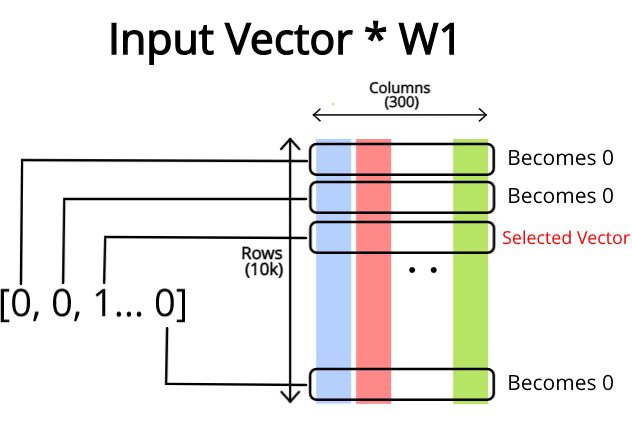

# 4. Model training using embedding layer and RNN (Baseline)

<a id="rnn"></a>


## 4.1 Baseline model 1 with SimpleRNN and embedding layer

<a id="base"></a>


In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dropout, Dense

# Pastikan total_words dan maxlen didefinisikan
total_words = 5000  # Contoh: jumlah kata dalam tokenizer
maxlen = 100        # Contoh: panjang maksimum sequence

# Baseline model
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=70, input_length=maxlen))  # Define input_length
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

# Build and summarize the model
model.build(input_shape=(None, maxlen))  # Optional, ensures input shape is set
model.summary()


e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 70)        │       350,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 100, 128)       │        17,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 100, 128)       │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,466 (1.52 MB)

 Trainable params: 397,466 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 What are the Recurrent Neural Networks??

<a id="rnets"></a>


- A major difference between densely connected neural network and recurrent nueral network, is that fully connected networks have no memory in units of each layer. while `recurrent nueral networks do store state of previous timestep or sequence` while assigning weights  to current input.

- In RNNs, we `process inputs word by word or eye saccade but eye saccade` - while keeping memories of what came before in each cells. this gives fluid representation of sequences and gives nueral network a ability to capture context of sequence rather than absolute representation of words.

> "Recurrent nueral network processes sequences by iterating through the sequence elements and maintaining a a `state` containing information relative to what it has seen so far. In effect, an RNN is a type of nueral network that has an internal loop."

-6.2 Understanding recurrent nueral network, Deep learning using python by chollat

- See the below depiction of how RNNs learns the context of sequences.

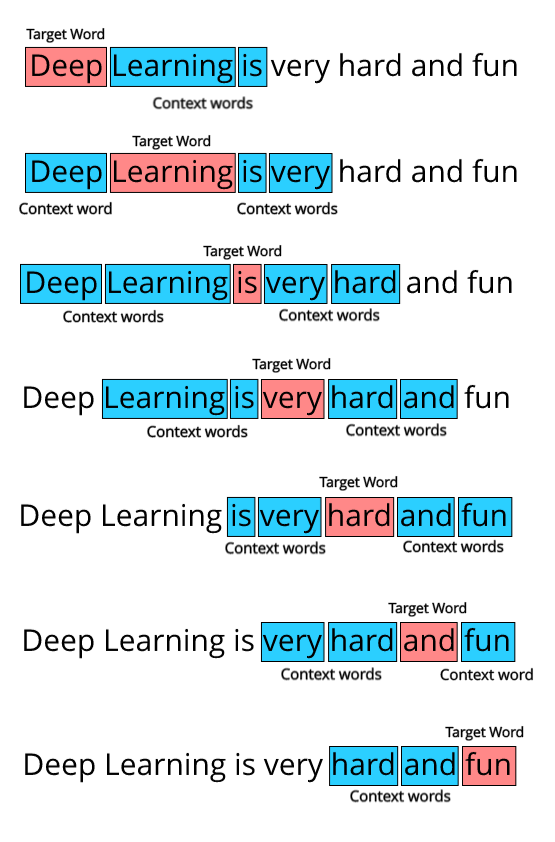

- A visual dipiction of RNN cell with a loop and unrolled RNN cell.

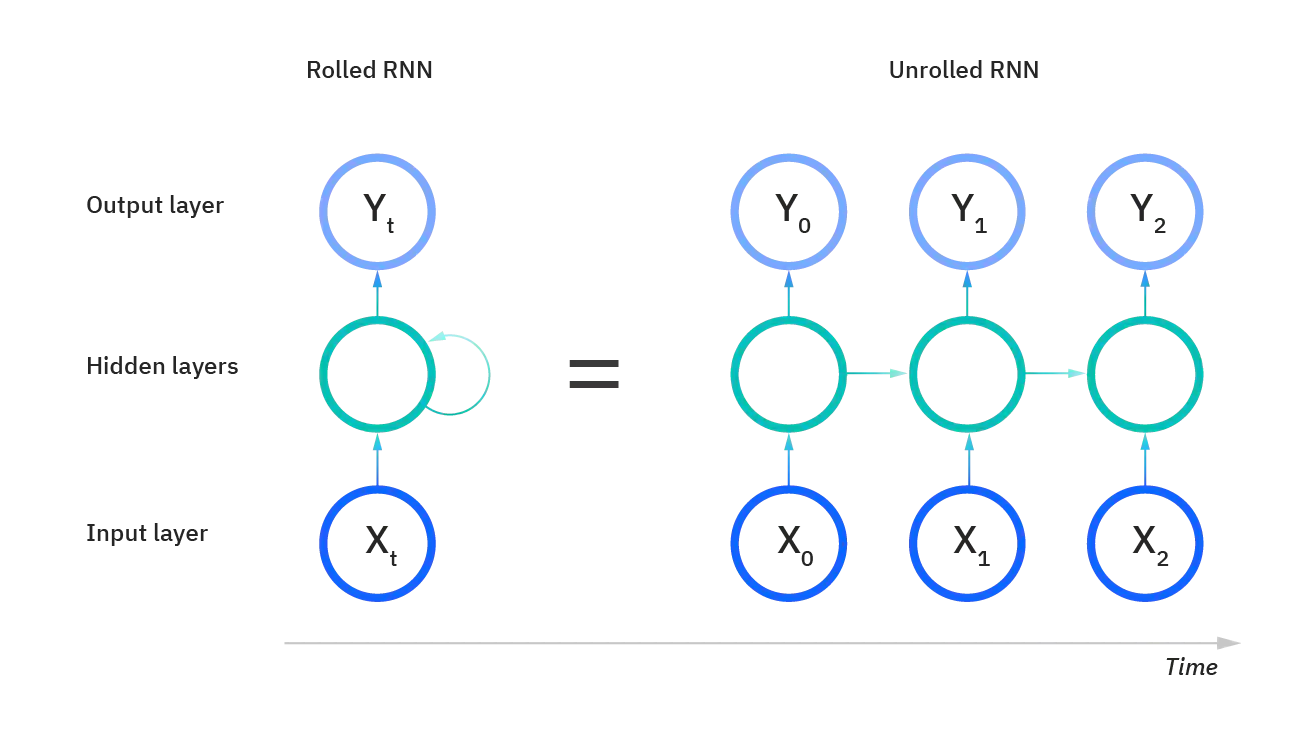

In [69]:
tokenizer = Tokenizer(num_words=5000, oov_token=None)  # Hilangkan token OOV


In [70]:
train_seq = [[token for token in seq if token < total_words] for seq in train_seq]
test_seq = [[token for token in seq if token < total_words] for seq in test_seq]


In [79]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # SETUP EARLY STOPPING CALLBACK
# earlystopping = EarlyStopping(
#     monitor='accuracy',  # Perbaikan dari 'moniter' ke 'monitor'
#     patience=5,
#     verbose=1,
#     mode='min'
# )

# # SETUP MODEL CHECKPOINT CALLBACK
# checkpointer = ModelCheckpoint(
#     filepath='best_model.keras',  # Ubah nama file menjadi format .keras
#     monitor='val_loss',  # Perbaikan dari 'moniter' ke 'monitor'
#     verbose=0,
#     save_best_only=True
# )

# callback_list = [checkpointer, earlystopping]

# # Fit model to the data
# history = model.fit(
#     train_padseq, y_train, 
#     batch_size=128, 
#     epochs=15, 
#     validation_split=0.2,
#     callbacks=callback_list  # Pastikan callbacks digunakan
# )

# # Evaluate the model
# test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
# print("Test loss and accuracy:", test_loss, test_acc)


Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node sequential_3_1/embedding_4_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\Annisa Fadila\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\Annisa Fadila\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\Annisa Fadila\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Annisa Fadila\AppData\Local\Temp\ipykernel_34484\516623833.py", line 22, in <module>

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\models\sequential.py", line 213, in call

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\models\functional.py", line 584, in call

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\layers\core\embedding.py", line 140, in call

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\ops\numpy.py", line 5206, in take

  File "e:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\myenv\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 2029, in take

indices[104,9] = 8092 is not in [0, 5000)
	 [[{{node sequential_3_1/embedding_4_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_29377]

**Notes:**

- Experiment 1: 
Parameters: max_words=100000, output_dim=50, maxlen=50, epoch=10.
Model is highly overfitting as training accuracy comes around 84% while test accuracy is barely 40%.

- Experiment 2:
Params: max_words=150000, out_dim=50, maxlen=80, epoch=10, added droput layers in RNN
Model do not overfit but underfit and biased. val_acc comes again almost 39.3% while train accuracy is only 42%. model needs more parameters with more epochs

- Experiment 3:
Params: max_words=total_words, out_dim=70, maxlen=100, epoch=15, addding bidirection layer over both dropout RNN
an improvement in train accuracy to 63% and val_accuracy to 49% max at epoch 13. after epoch 13 model started overfitting. (next step) model can be more complex with regularization, model is forgetting information after 3rd RNN layer due to lower number of units, this needs to be solved.

In [104]:
model.save("model1.h5")

## 4.3 Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

<a id="model2"></a>


In [75]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, SimpleRNN, GRU, Conv1D, MaxPooling1D, Dropout, Dense

# Define maxlen (sequence length) and total_words (vocabulary size)
maxlen = 130  # Sequence length, adjust according to your dataset
total_words = 5000  # Vocabulary size for embedding layer

# Create the model
model2 = Sequential()

# Add the embedding layer (input_dim=total_words, input_length=maxlen)
model2.add(Embedding(input_dim=total_words, output_dim=100, input_length=maxlen))  # Ensure this matches your data shape

# Add bidirectional LSTM layers
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))

# Another bidirectional LSTM layer
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))

# Add bidirectional SimpleRNN layer
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))

# Add a Conv1D layer
model2.add(Conv1D(72, 3, activation='relu'))

# Max pooling layer to reduce the sequence length
model2.add(MaxPooling1D(2))

# Add SimpleRNN and GRU layers
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, kernel_regularizer=regularizers.l1_l2()))

# Add dropout and the final output layer
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='softmax'))

# Compile the model (this also triggers model building)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now, build the model explicitly (you can also skip this as compiling should trigger build)
model2.build(input_shape=(None, maxlen))

# Print the model summary
model2.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 130, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 130, 128)       │        84,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 130, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 130, 128)       │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 128, 72)        │        27,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 64, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ (None, 64, 64)         │         8,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770,098 (2.94 MB)

 Trainable params: 770,098 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

**Notes:**

- Experiment 4: params: max_words=total_words, out_dim=70, maxlen=100, epoch=15, in this case out train and test accuracy improved but model is again overfitting as train accuracy is at 74% while test accuray is at 49%. to avoid overfitting we need ot increase maxlen and output dimensions of vector and also adding CNN1D layer after 3rd RNN with gloablmax pooling with regularization should help, also GRU can be considered

- Experiment 5: params: max_words=total_words, out_dim=100, maxlen=130, epoch=15, train accuracy=71%, test accuracy=49%, not any significant difference than previous model, (next up)add  GRU, cnn1d with globalmaxpooling at the end, with shuffling of train data and run the notebook again

- Experiment 6: params: max_words=total_words, out_dim=100, maxlen=130, epoch=15, train accuracy=85%, test accuracy=50%, we used LSTMs and GRU to process long sequences and retain previous inputs at perticuler input. while train accuracy improved significantly, test accuracy is still at 50%, a marginal improvement. Text data is always hard problem owing distribution on inputs. NlP models generally requires huge data to gain maximum accuracy on testing data. pre-trained models like BERT, Roberta can be used to overcome these challanges.\\

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Menentukan jumlah total kata dari tokenizer
total_words = len(tokenizer.word_index) + 1

# Membuat model dengan input_dim sesuai total_words
model2 = Sequential()
model2.add(Embedding(input_dim=total_words, output_dim=70, input_length=20))  # Sesuaikan input_length
model2.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.2, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.3, activation='tanh', return_sequences=True)))
model2.add(SimpleRNN(32, activation='tanh'))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='softmax'))  # Output sesuai dengan 10 kategori

# Kompilasi model
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Setup Early Stopping dan Model Checkpoint Callbacks
earlystopping = EarlyStopping(monitor='val_loss',  # Monitor 'val_loss' agar relevan untuk validasi
                              patience=5,
                              verbose=1,
                              mode='min')

checkpointer = ModelCheckpoint(filepath='bestvalue1.keras', 
                                monitor='val_loss', 
                                verbose=0, 
                                save_best_only=True)

callback_list = [checkpointer, earlystopping]

# Fit model dengan data
history2 = model2.fit(train_padseq, y_train, 
                      batch_size=128, 
                      epochs=15, 
                      validation_split=0.2,
                      shuffle=True,
                      callbacks=callback_list)

# Evaluasi model pada data test
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("Test loss and accuracy:", test_loss2, test_acc2)


Epoch 1/15
948/948 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - accuracy: 0.2430 - loss: 1.9706 - val_accuracy: 0.4797 - val_loss: 1.5246
Epoch 2/15
948/948 ━━━━━━━━━━━━━━━━━━━━ 60s 63ms/step - accuracy: 0.5069 - loss: 1.4776 - val_accuracy: 0.5529 - val_loss: 1.3735
Epoch 3/15
948/948 ━━━━━━━━━━━━━━━━━━━━ 61s 64ms/step - accuracy: 0.5991 - loss: 1.2403 - val_accuracy: 0.5953 - val_loss: 1.2867
Epoch 4/15
948/948 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.6637 - loss: 1.0658 - val_accuracy: 0.6290 - val_loss: 1.1673
Epoch 5/15
948/948 ━━━━━━━━━━━━━━━━━━━━ 68s 71ms/step - accuracy: 0.6982 - loss: 0.9692 - val_accuracy: 0.6386 - val_loss: 1.1617
Epoch 6/15
948/948 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.7252 - loss: 0.8871 - val_accuracy: 0.6469 - val_loss: 1.1414
Epoch 7/15
948/948 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.7465 - loss: 0.8280 - val_accuracy: 0.6491 - val_loss: 1.1264
Epoch 8/15
948/948 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.7680 - loss: 0.7642 - 

In [77]:
model.save("model2(10 kategori).h5")

## 4.4 learning curve of model 2

<a id="loss"></a>


In [63]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

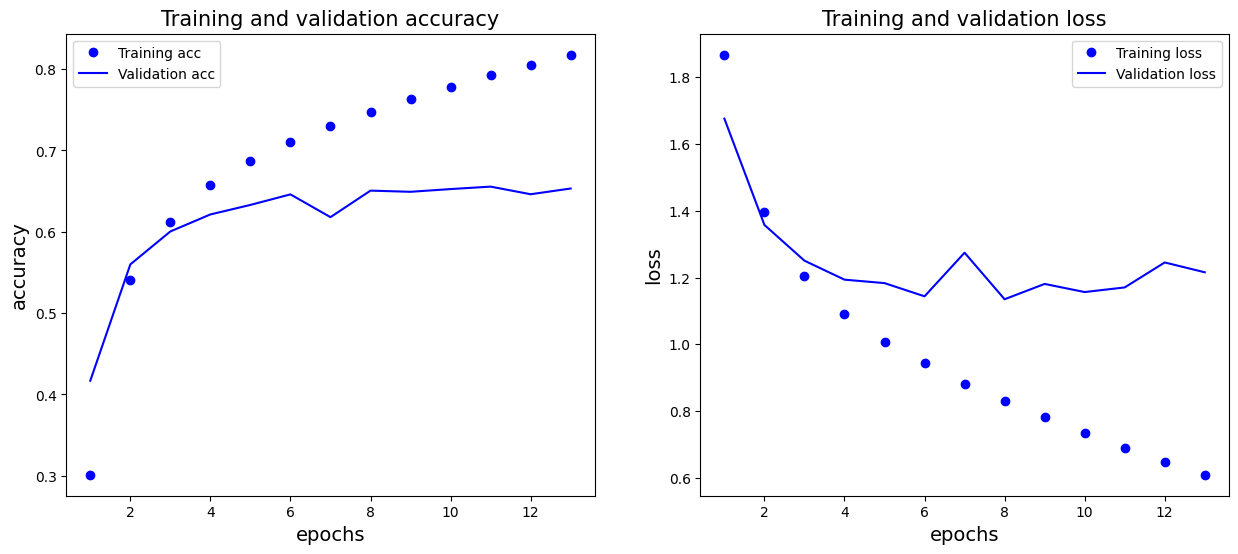

In [64]:
plot_loss_accuracy(history2)

# 5. Conclusion

<a id="conclude"></a>


1. In this notebook, we explored some of text data visualization techniques to derive insights out of text data and make use of them into model training.

2. We built first model using simpleRNN and embedding layer of keras where we found maximum of 49% accuracy on test data and also noticed foregtting of model due to large sequences of inputs.

3. In our second model, we trained model using LSTMs and GRU for retaining information of longer sequences. we could 'optimize' model as it improved accuracy of training data significantly but it could not 'generalize well' enough on unseen data.

# Cek

In [105]:
import pickle

# Simpan tokenizer ke file
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer berhasil disimpan.")


Tokenizer berhasil disimpan.


In [79]:
import pickle

# Simpan LabelEncoder ke file
with open('label_encoder2.pkl', 'wb') as file:
    pickle.dump(encoder, file)

print("LabelEncoder berhasil disimpan ke file 'label_encoder2.pkl'")


LabelEncoder berhasil disimpan ke file 'label_encoder2.pkl'


In [83]:
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Muat Tokenizer, LabelEncoder, dan Model
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

with open('label_encoder2.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

model = load_model('model2(10 kategori).h5')

# 2. Proses Input Text
input_text = ["shell go near ukraine nuclear plant despite risksthe head international atomic energy agency warn un security council something catastrophic could take place zaporizhzhia"]

# Tokenisasi dan Padding
input_seq = tokenizer.texts_to_sequences(input_text)
input_padseq = pad_sequences(input_seq, maxlen=130)  # Sesuaikan maxlen dengan model Anda

# 3. Prediksi Kategori
predictions = model.predict(input_padseq)

# Ambil Kategori dengan Probabilitas Tertinggi
predicted_class_index = np.argmax(predictions, axis=1)  # Index kategori
predicted_class = label_encoder.inverse_transform(predicted_class_index)  # Label kategori

# 4. Tampilkan Hasil
print("Prediksi Kategori:", predicted_class[0])
print("Probabilitas:", predictions[0][predicted_class_index[0]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
Prediksi Kategori: Science
Probabilitas: 0.22234309
[0.06135177 0.05864585 0.10820585 0.07476513 0.12581989 0.11480699
 0.22234309 0.14199145 0.05965621 0.0324138 ]
